In [1]:
import numpy as np 
import pandas as pd
import os
import scipy.stats as ss
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error,mean_squared_error
from sklearn.model_selection import GridSearchCV
from scipy.stats import f_oneway
import pandas as pd
import datetime
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # 텐서플로가 첫 번째 GPU에 1GB 메모리만 할당하도록 제한
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
  except RuntimeError as e:
    # 프로그램 시작시에 가상 장치가 설정되어야만 합니다
    print(e)

In [3]:
# 데이터 불러오기
past_sales = pd.read_csv('C:/Users/rlaeo/OneDrive/바탕 화면/rossmann.csv')
store = pd.read_csv('C:/Users/rlaeo/OneDrive/바탕 화면/store.csv')

# 데이터 제거
store = store.drop(['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'], axis=1)

# 데이터 병합
data = pd.merge(left = past_sales,right = store, on = 'Store', how = 'right')

# 날짜
data['Date'] = pd.to_datetime(data['Date'], format="%Y-%m-%d")
data['Year']=pd.DatetimeIndex(data.Date).year
data['Month']=pd.DatetimeIndex(data.Date).month
data['Day']=pd.DatetimeIndex(data.Date).day
data = data.drop(['Date'],axis=1)

# 데이터 가공 : StateHoliday, Open
data['StateHoliday'] = data['StateHoliday'].replace({0:'d'}) # 0 값은 d로 대체
data['StateHoliday'] = data['StateHoliday'].replace({'0':'d'})# 0 값은 d로 대체
open = data[data['Open']==0].index
data.drop(open,inplace=True)


# 결측값 처리
data = data.dropna(axis=0)

# store,open 이름 제거
data = data.drop(['Open'],axis=1)

# 데이터 분리(수치형, 범주형)
digital_cols = ['Sales', 'Customers', 'CompetitionDistance', 'Year','Month', 'Day']
digital_data = data[digital_cols]
digital_data = pd.DataFrame(digital_data.values, columns = digital_cols)
digital_data
# 표준화
scaler = MinMaxScaler().fit(digital_data)

digital_data = pd.DataFrame(scaler.transform(digital_data),index = digital_data.index, columns = digital_cols)

categorey_clos = data.columns.drop(digital_cols)
categorey_data = data[categorey_clos]
categorey_data = pd.DataFrame(categorey_data.values, columns = categorey_clos)

# 인코딩
onehotencoding_cols = ['StateHoliday', 'StoreType', 'Assortment', 'DayOfWeek']
categorey_data = pd.get_dummies(data=categorey_data, columns=onehotencoding_cols)


# 데이터 병합
data = pd.concat([digital_data, categorey_data], axis = 1)

# 형 통일
data = data.astype({'Promo2':'int', 'StateHoliday_b':'int', 'StateHoliday_c':'int', 'StateHoliday_d':'int', 'StoreType_a':'int', 'StoreType_b':'int', 'StoreType_c':'int', 'StoreType_d':'int'})
data = data.astype({'Assortment_a':'int', 'Assortment_b':'int', 'Assortment_c':'int', 'DayOfWeek_1':'int', 'DayOfWeek_2':'int', 'DayOfWeek_3':'int', 'DayOfWeek_4':'int', 'DayOfWeek_5':'int', 'DayOfWeek_6':'int', 'DayOfWeek_7':'int'})

pd.options.display.max_columns = None
data['StateHoliday_a'] = data['StateHoliday_a'].replace({True: 1, False: 0})
data

C:\Users\rlaeo\AppData\Local\Temp\ipykernel_25620\2548748974.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  past_sales = pd.read_csv('C:/Users/rlaeo/OneDrive/바탕 화면/rossmann.csv')


,Sales,Customers,CompetitionDistance,Year,Month,Day,Store,Promo,SchoolHoliday,Promo2,StateHoliday_a,StateHoliday_b,StateHoliday_c,StateHoliday_d,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7
0,0.126664,0.075122,0.016482,1.0,0.545455,1.000000,1,1,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0
1,0.120815,0.073904,0.016482,1.0,0.545455,0.966667,1,1,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0
2,0.115087,0.070790,0.016482,1.0,0.545455,0.933333,1,1,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0
3,0.120599,0.075799,0.016482,1.0,0.545455,0.900000,1,1,1,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0
4,0.146856,0.082837,0.016482,1.0,0.545455,0.866667,1,1,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
842201,0.166181,0.063752,0.070280,0.0,0.000000,0.200000,1115,1,1,1,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0,0,0,0
842202,0.114823,0.045885,0.070280,0.0,0.000000,0.133333,1115,0,1,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0
842203,0.109263,0.044126,0.070280,0.0,0.000000,0.100000,1115,0,1,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0
842204,0.103415,0.040606,0.070280,0.0,0.000000,0.066667,1115,0,1,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0


In [34]:
data = data[(data['Store'] >= 1) & (data['Store'] <= 300)]

data

KeyError: 'Store'

In [5]:
target_col = 'Sales'
features_cols = data.columns.drop(target_col)        
features = data[features_cols]
target = data[target_col]
target = pd.DataFrame(target.values.reshape(-1,1))
features = features.values
target = target.values
seed = 0
np.random.seed(seed)
tf.compat.v1.set_random_seed(seed)

In [6]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=seed,shuffle=True)
print('train_data의 row : %s, column : %s row : %s, column : %s'%(x_train.shape[0],x_train.shape[1],x_test.shape[0],x_test.shape[1]))
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

train_data의 row : 6256, column : 27 row : 1564, column : 27


In [7]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(256,input_dim = 27,activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(128,activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(1))

model.compile(optimizer='adam',
             loss='mse',
             metrics=['accuracy'])

In [8]:
history = model.fit(x_train, y_train,
                    batch_size=64,
                    epochs=5,
)

Epoch 1/5
98/98 [==============================] - 2s 2ms/step - loss: 0.6441 - accuracy: 0.0000e+00
Epoch 2/5
98/98 [==============================] - 0s 4ms/step - loss: 0.2634 - accuracy: 0.0000e+00
Epoch 3/5
98/98 [==============================] - 0s 3ms/step - loss: 0.1337 - accuracy: 0.0000e+00
Epoch 4/5
98/98 [==============================] - 0s 4ms/step - loss: 0.0688 - accuracy: 0.0000e+00
Epoch 5/5
98/98 [==============================] - 0s 4ms/step - loss: 0.0341 - accuracy: 0.0000e+00


In [9]:
y_prediction = model.predict(x_test).flatten()
a = 0
b = 0
for i in range(10):
    label = np.round(y_test[i],3)
    prediction = np.round(y_prediction[i],3)
    print("실제가격 %0.3f 예상 가격 %.3f" %(label,prediction))
    a += label
    b += prediction
a = a/10
b = b/10
print("실제가격 평균값 : %0.3f" %a)
print("실제가격 예상값 : %0.3f" %b)

49/49 [==============================] - 0s 901us/step
실제가격 0.070 예상 가격 0.050
실제가격 0.123 예상 가격 0.128
실제가격 0.138 예상 가격 0.153
실제가격 0.086 예상 가격 0.121
실제가격 0.105 예상 가격 0.066
실제가격 0.103 예상 가격 0.106
실제가격 0.286 예상 가격 0.224
실제가격 0.160 예상 가격 0.159
실제가격 0.161 예상 가격 0.130
실제가격 0.104 예상 가격 0.126
실제가격 평균값 : 0.134
실제가격 예상값 : 0.126


49/49 [==============================] - 0s 2ms/step
실제가격 0.070 예상 가격 0.050
실제가격 0.123 예상 가격 0.128
실제가격 0.138 예상 가격 0.153
실제가격 0.086 예상 가격 0.121
실제가격 0.105 예상 가격 0.066
실제가격 0.103 예상 가격 0.106
실제가격 0.286 예상 가격 0.224
실제가격 0.160 예상 가격 0.159
실제가격 0.161 예상 가격 0.130
실제가격 0.104 예상 가격 0.126
편차 -0.007


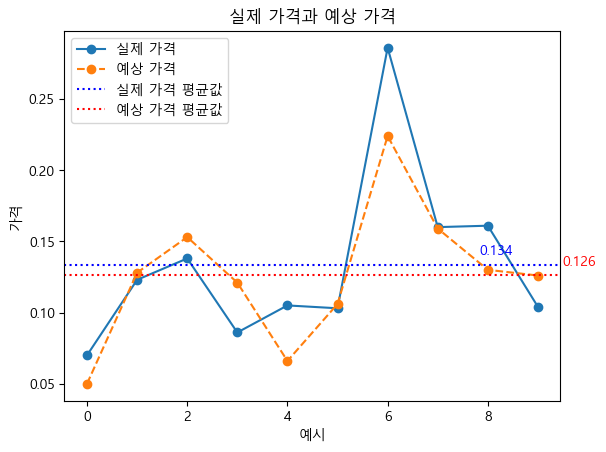

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import os


# Mac OS의 경우와 그 외 OS의 경우로 나누어 설정

if os.name == 'posix':
    plt.rc("font", family="AppleGothic")
else:
    plt.rc("font", family="Malgun Gothic")
y_prediction = model.predict(x_test).flatten()

# 라벨과 예측 값을 저장할 리스트
labels = []
predictions = []

# 10개씩 라벨과 예측 값을 저장
for i in range(10):
    label = np.round(y_test[i],3)
    prediction = np.round(y_prediction[i], 3)
    labels.append(label)
    predictions.append(prediction)
    print("실제가격 %0.3f 예상 가격 %.3f" % (label, prediction))

# 평균 값 계산
average_label = np.mean(labels)
average_prediction = np.mean(predictions)
print("편차 %0.3f" %(average_prediction-average_label))
# 그래프 생성
x = np.arange(10)
plt.plot(x, labels, label='실제 가격', marker='o')
plt.plot(x, predictions, label='예상 가격', linestyle='dashed', marker='o')

# 평균 값 표시
plt.axhline(y=average_label, color='b', linestyle='dotted', label='실제 가격 평균값')
plt.axhline(y=average_prediction, color='r', linestyle='dotted', label='예상 가격 평균값')

# 그래프 설정
plt.xlabel('예시')
plt.ylabel('가격')
plt.title('실제 가격과 예상 가격')
plt.legend()

# 레이블 표시0


# 평균 값 레이블 표시
plt.annotate(f'{average_label:.3f}', (x[-1], average_label), textcoords="offset points", xytext=(-30, 5), ha='center', va='bottom', color='blue')
plt.annotate(f'{average_prediction:.3f}', (x[-1], average_prediction), textcoords="offset points", xytext=(30, 5), ha='center', va='bottom', color='red')

plt.show()
